<h1 style="text-align: center; font-weight: bold;"><u>Import et chargement des données</u></h1>

In [608]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

<h1 style="text-align: center; font-weight: bold;"><u>Étape 1 Requêtes SQL</u></h1>

In [609]:
# Chemin vers la base de données SQLite
db_path = 'data/olist.db'

# Créer une connexion à la base de données SQLite
conn = sqlite3.connect(db_path)

In [610]:
# Définir la requête SQL
# En excluant les commandes annulées, quelles sont les commandes
#  récentes de moins de 3 mois que les clients ont reçues avec au moins 3
#  jours de retard 
query1 = """
SELECT 
    o.order_id, 
    o.order_status, 
    o.order_purchase_timestamp, 
    o.order_delivered_customer_date, 
    o.order_estimated_delivery_date
FROM 
    orders o
WHERE 
    o.order_status != 'canceled'
    AND o.order_purchase_timestamp >= (
        SELECT DATE(MAX(order_purchase_timestamp), '-3 months')
        FROM orders
    )
    AND JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_estimated_delivery_date) >= 3;

"""

# Exécuter la requête et charger les résultats dans un DataFrame
df = pd.read_sql_query(query1, conn)

In [611]:
print(df.shape[0])

322


In [612]:
# Afficher les résultats
df.head()  # Affiche les 5 premières lignes du DataFrame

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,cfa4fa27b417971e86d8127cb688712f,delivered,2018-08-16 09:44:23,2018-08-29 01:41:41,2018-08-22 00:00:00
1,234c056c50619f48da64f731c48242b4,delivered,2018-08-14 14:49:15,2018-09-01 18:14:42,2018-08-23 00:00:00
2,8ad3f1d0f96992e43566c4c82c9f6c58,delivered,2018-07-17 21:25:29,2018-08-14 04:04:40,2018-08-03 00:00:00
3,7f579e203c931f3e8410103359c6d523,delivered,2018-08-02 18:09:27,2018-08-13 20:11:47,2018-08-09 00:00:00
4,cb6e441ff2ef574ce08d3709426f88ec,delivered,2018-08-08 19:27:03,2018-08-18 01:11:58,2018-08-15 00:00:00


In [613]:
# Définir la requête SQL
# Qui sont les vendeurs ayant généré un chiffre d'affaires de plus de 100
#  000Real sur des commandeslivrées via Olist ?
 
query2 = """
SELECT oi.seller_id, SUM(oi.price) AS total_revenue
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
WHERE o.order_status = 'delivered'
GROUP BY oi.seller_id
HAVING total_revenue > 100000;
"""

# Exécuter la requête et charger les résultats dans un DataFrame
df = pd.read_sql_query(query2, conn)

In [614]:
print(df.shape[0])

17


In [615]:
# Afficher les résultats
# Augmenter le nombre de lignes affichées
pd.set_option('display.max_rows', None)
df.head()  # Affiche les 5 premières lignes du DataFrame

,seller_id,total_revenue
0,1025f0e2d44d7041d6cf58b6550e0bfa,138208.56
1,1f50f920176fa81dab994f9023523100,106655.71
2,46dc3b2cc0980fb8ec44634e21d2718e,122811.38
3,4869f7a5dfa277a7dca6462dcf3b52b2,226987.93
4,4a3ca9315b744ce9f8e9374361493884,196882.12


In [616]:
# Définir la requête SQL
 # Qui sont les nouveaux vendeurs (moins de 3 mois d'ancienneté) qui
 # sont déjà très engagés avec la plateforme (ayant déjà vendu plus de 30
 # produits) ?
query3 = """
WITH max_order_date AS (
    SELECT MAX(order_purchase_timestamp) AS max_date
    FROM orders
),
first_sale_per_seller AS (
    SELECT 
        oi.seller_id,
        MIN(o.order_purchase_timestamp) AS first_sale_date
    FROM 
        order_items oi
        JOIN orders o ON oi.order_id = o.order_id
    GROUP BY 
        oi.seller_id
),
sales_last_3_months AS (
    SELECT 
        oi.seller_id,
        COUNT(*) AS products_sold
    FROM 
        order_items oi
        JOIN orders o ON oi.order_id = o.order_id
        JOIN max_order_date m ON 1=1
    WHERE 
        o.order_purchase_timestamp >= DATE(m.max_date, '-3 months')
    GROUP BY 
        oi.seller_id
)
SELECT 
    fs.seller_id,
    fs.first_sale_date,
    sl.products_sold
FROM 
    first_sale_per_seller fs
    JOIN sales_last_3_months sl ON fs.seller_id = sl.seller_id
    JOIN max_order_date m ON 1=1
WHERE 
    fs.first_sale_date >= DATE(m.max_date, '-3 months')
    AND sl.products_sold > 30
;

"""

# Exécuter la requête et charger les résultats dans un DataFrame
df = pd.read_sql_query(query3, conn)

In [617]:
print(df.shape[0])

3


In [618]:
# Afficher les résultats
df.head()  # Affiche les 5 premières lignes du DataFrame

,seller_id,first_sale_date,products_sold
0,240b9776d844d37535668549a396af32,2018-07-17 13:48:59,36
1,81f89e42267213cb94da7ddc301651da,2018-08-08 12:45:12,52
2,d13e50eaa47b4cbe9eb81465865d8cfc,2018-08-04 09:09:37,69


In [619]:
# Définir la requête SQL
 # Question : Quels sont les 5 codes postaux, enregistrant plus de 30
 # reviews, avec le pire review score moyen sur les 12 derniers mois 
query4 = """
WITH max_order_date AS (
    SELECT MAX(order_purchase_timestamp) AS max_date
    FROM orders
),
filtered_reviews AS (
    SELECT 
        r.review_score,
        c.customer_zip_code_prefix
    FROM 
        order_reviews r
        JOIN orders o ON r.order_id = o.order_id
        JOIN customers c ON o.customer_id = c.customer_id
        JOIN max_order_date m ON 1=1
    WHERE 
        o.order_purchase_timestamp >= DATE(m.max_date, '-12 months')
),
reviews_aggregated AS (
    SELECT 
        customer_zip_code_prefix,
        COUNT(*) AS review_count,
        AVG(review_score) AS avg_review_score
    FROM 
        filtered_reviews
    GROUP BY 
        customer_zip_code_prefix
    HAVING 
        review_count > 30
)
SELECT 
    customer_zip_code_prefix,
    review_count,
    avg_review_score
FROM 
    reviews_aggregated
ORDER BY 
    avg_review_score ASC
LIMIT 5;

"""

# Exécuter la requête et charger les résultats dans un DataFrame
df = pd.read_sql_query(query4, conn)

In [620]:
print(df.shape[0])

5


In [621]:
# Afficher les résultats
df.head(20)  # Affiche les 5 premières lignes du DataFrame

,customer_zip_code_prefix,review_count,avg_review_score
0,22753,47,2.808511
1,22770,37,3.135135
2,22793,90,3.233333
3,21321,36,3.277778
4,22780,37,3.351351


In [622]:
# Définir la requête SQL
 # Question : Quels sont les 5 codes postaux, enregistrant plus de 30
 # reviews, avec le pire review score moyen sur les 12 derniers mois 
query5 = """
WITH max_order_date AS (
    SELECT MAX(order_purchase_timestamp) AS max_date
    FROM orders
),
reviews_last_12_months AS (
    SELECT 
        r.review_id,
        r.review_score,
        o.customer_id
    FROM 
        order_reviews r
        JOIN orders o ON r.order_id = o.order_id
        JOIN max_order_date m ON 1=1
    WHERE 
        o.order_purchase_timestamp >= DATE(m.max_date, '-12 months')
),
reviews_with_zipcode AS (
    SELECT 
        rl.review_score,
        c.customer_zip_code_prefix
    FROM 
        reviews_last_12_months rl
        JOIN customers c ON rl.customer_id = c.customer_id
)
SELECT 
    rwz.customer_zip_code_prefix,
    COUNT(*) AS review_count,
    AVG(rwz.review_score) AS avg_review_score
FROM 
    reviews_with_zipcode rwz
GROUP BY 
    rwz.customer_zip_code_prefix
HAVING 
    review_count > 30
ORDER BY 
    avg_review_score ASC
LIMIT 5;

"""

# Exécuter la requête et charger les résultats dans un DataFrame
df = pd.read_sql_query(query5, conn)

In [623]:
print(df.shape[0])

5


In [624]:
# Afficher les résultats
df.head()  # Affiche les 5 premières lignes du DataFrame

,customer_zip_code_prefix,review_count,avg_review_score
0,22753,47,2.808511
1,22770,37,3.135135
2,22793,90,3.233333
3,21321,36,3.277778
4,22780,37,3.351351


<h1 style="text-align: center; font-weight: bold;"><u>Étape 2 feature engineering</u></h1>

In [625]:
query = """
WITH max_date AS (
    SELECT MAX(order_purchase_timestamp) AS global_max_date
    FROM orders
),
customer_orders AS (
    SELECT 
        c.customer_unique_id,
        o.order_id,
        o.order_purchase_timestamp
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
),
payments AS (
    SELECT 
        co.customer_unique_id,
        MAX(co.order_purchase_timestamp) AS last_order_date,
        COUNT(DISTINCT co.order_id) AS frequency,
        SUM(op.payment_value) AS monetary
    FROM customer_orders co
    JOIN order_pymts op ON co.order_id = op.order_id
    GROUP BY co.customer_unique_id
),
rfm AS (
    SELECT 
        p.customer_unique_id,
        CAST(JULIANDAY(m.global_max_date) - JULIANDAY(p.last_order_date) AS INT) AS recency,
        p.frequency,
        ROUND(p.monetary, 2) AS monetary
    FROM payments p
    CROSS JOIN max_date m
)

SELECT *
FROM rfm
ORDER BY recency DESC;

"""
# Exécuter la requête et charger les résultats dans un DataFrame
df = pd.read_sql_query(query, conn)

In [626]:
df.head()

,customer_unique_id,recency,frequency,monetary
0,4854e9b3feff728c13ee5fc7d1547e92,772,1,75.06
1,b7d76e111c89f7ebf14761390f0f7d17,772,1,136.23
2,009b0127b727ab0ba422f6d9604487c7,764,1,40.95
3,0eb1ee9dba87f5b36b4613a65074337c,744,1,109.34
4,2f64e403852e6893ae37485d5fcacdaf,744,1,39.09


In [590]:
df[['recency', 'frequency', 'monetary']].describe()

,recency,frequency,monetary
count,96095.000000,96095.000000,96095.000000
mean,287.730756,1.034809,166.594226
std,153.407846,0.214385,231.428912
min,0.000000,1.000000,0.000000
25%,163.000000,1.000000,63.120000
50%,268.000000,1.000000,108.000000
75%,397.000000,1.000000,183.530000
max,772.000000,17.000000,13664.080000


🔁 Recency (nombre de jours depuis la dernière commande)
Min = 0 → certains clients ont passé une commande aujourd’hui (par rapport à la date max de ta base).

Max = 772 → certains clients n’ont pas commandé depuis plus de 2 ans.

Moyenne ≈ 288 jours, Médiane = 268 jours → la majorité n’a pas commandé depuis environ 9 mois.

Interprétation : la base contient beaucoup de clients inactifs ou peu récents.

🔂 Frequency (nombre de commandes distinctes)
Min = 1, 25%/50%/75% = 1 → au moins 75 % des clients n’ont commandé qu’une seule fois.

Max = 17 → très peu de clients fidèles (multi-acheteurs).

Moyenne ≈ 1.03 → presque tous les clients sont des acheteurs uniques.

Interprétation : Visiblement la fidélité des clients est très faible.

💰 Monetary (valeur monétaire cumulée des commandes)
Min = 0 → certains clients ont des paiements nuls (annulations, remboursements ?).

Médiane = 108 €, Moyenne ≈ 167 €, mais Max = 13 664 € → très forte asymétrie (quelques gros clients tirent la moyenne vers le haut).

Interprétation : la distribution est très déséquilibrée (longue traîne), il faut probablement la transformer (e.g. log).

✅ Conclusion

Il y a beaucoup de clients inactifs (forte récence).

Presque tous sont des acheteurs uniques.

Les dépenses sont concentrées sur une minorité.

📊 Résumé des statistiques utiles

| RFM       | Min | 25% | 50% | 75% | Max   |
|-----------|-----|-----|-----|-----|--------|
| Recency   | 0   | 163 | 268 | 397 | 772    |
| Frequency | 1   | 1   | 1   | 1   | 17     |
| Monetary  | 0   | 63  | 108 | 183 | 13664  |


In [591]:
# On suppose que df contient les colonnes: 'customer_unique_id', 'recency', 'frequency', 'monetary'

# Récence : plus c'est petit, mieux c'est → 4 = client très récent
df['R_score'] = pd.qcut(df['recency'], q=4, labels=[4, 3, 2, 1]).astype(int)

# Fréquence : plus c'est élevé, mieux c'est
df['F_score'] = pd.qcut(df['frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4]).astype(int)

# Monétaire : plus c'est élevé, mieux c'est
df['M_score'] = pd.qcut(df['monetary'], q=4, labels=[1, 2, 3, 4]).astype(int)


In [592]:
df['RFM_score'] = df['R_score'].astype(str) + df['F_score'].astype(str) + df['M_score'].astype(str)


In [593]:
def segment_rfm(row):
    r, f, m = row['R_score'], row['F_score'], row['M_score']
    
    if r == 4 and f == 4 and m == 4:
        return 'Champions'
    elif r >= 3 and f >= 3:
        return 'Fidèles'
    elif r == 4:
        return 'Nouveaux clients'
    elif f >= 3 and m >= 3:
        return 'Clients rentables'
    elif r <= 2 and f <= 2:
        return 'À risque'
    elif r <= 2 and f >= 3:
        return 'À réactiver'
    else:
        return 'Autres'

df['segment'] = df.apply(segment_rfm, axis=1)


In [594]:
df['segment'].value_counts()

segment
À risque             46677
Fidèles              41084
Champions             5620
Autres                1371
Clients rentables     1165
À réactiver            178
Name: count, dtype: int64

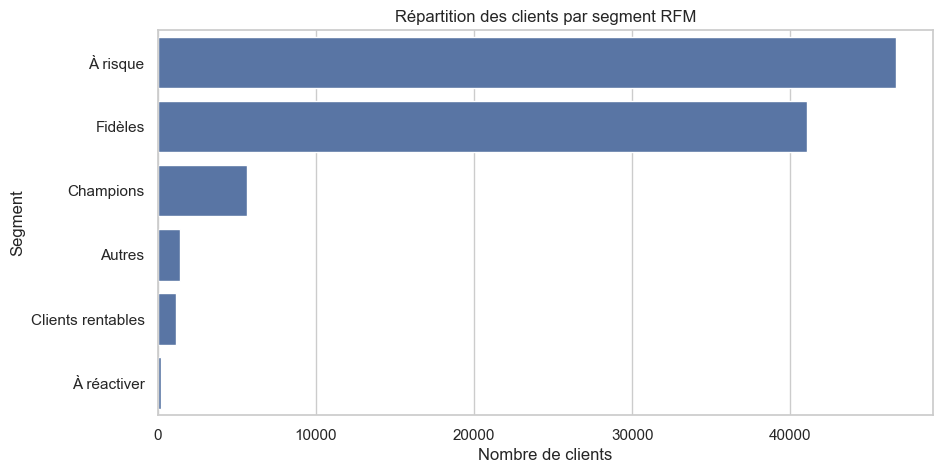

In [595]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='segment', order=df['segment'].value_counts().index)
plt.title('Répartition des clients par segment RFM')
plt.xlabel('Nombre de clients')
plt.ylabel('Segment')
plt.show()

| Segment              | Interprétation                                                                 | Taille  | Action recommandée                                                           |
|----------------------|--------------------------------------------------------------------------------|---------|-------------------------------------------------------------------------------|
| À risque             | Clients qui ont acheté il y a longtemps, peu souvent, et avec un panier moyen faible. | 46 677  | ⚠️ À relancer par des promotions ciblées, newsletters, ou offres de retour.   |
| Fidèles              | Clients avec une bonne fréquence d’achat mais pas forcément récents.          | 41 084  | ✅ Les entretenir : programme fidélité, offres spéciales, personnalisation.   |
| Champions            | Clients récents, fréquents, avec un bon panier moyen.                         | 5 620   | 👑 À choyer ! Offres VIP, accès exclusif, ambassadeurs de la marque.         |
| Autres               | Clients moyens ou nouveaux sans comportement tranché.                         | 1 371   | 🔍 À observer, potentiellement à faire monter en fidélité.                   |
| Clients rentables    | Clients avec un panier moyen élevé, mais pas forcément récents ou fréquents. | 1 165   | 💰 Mettre en avant des offres premium, ou ventes privées.                    |
| À réactiver          | Clients avec un bon historique, mais qui n'ont pas acheté récemment.          | 178     | ⏳ Campagnes de réactivation, rappel produits ou avantages non utilisés.     |


<h1 style="text-align: center; font-weight: bold;"><u>Étape 3 Modèle de clustering</u></h1>

In [596]:
rfm_features = df[['recency', 'frequency', 'monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

<h2 style="font-weight: bold;">3.A)<u>KMEANS</u></h2> 

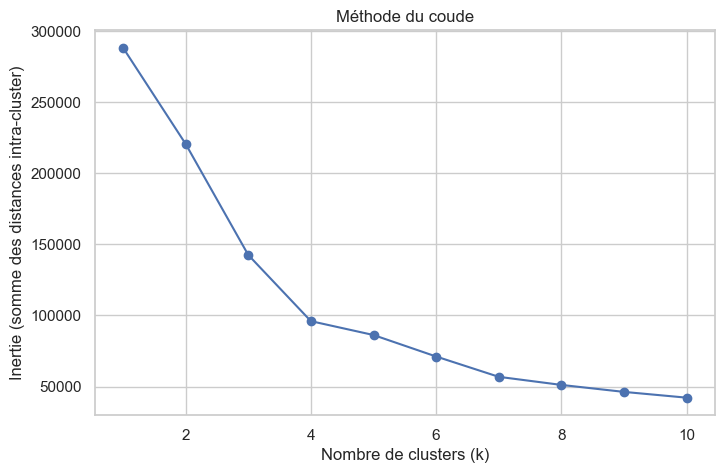

In [597]:
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie (somme des distances intra-cluster)')
plt.grid(True)
plt.show()

In [598]:
# KMeans avec k=4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)

# Ajouter les labels au DataFrame original
df['kmeans_cluster'] = kmeans.labels_

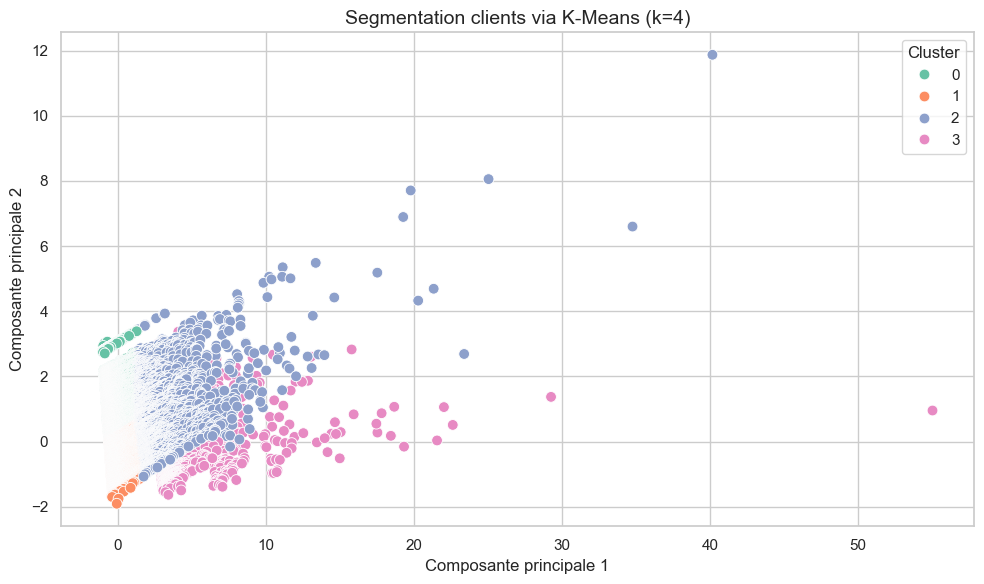

In [599]:
# Réduction à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Ajout des colonnes PCA pour visualisation
df['PCA1'] = rfm_pca[:, 0]
df['PCA2'] = rfm_pca[:, 1]

# Visualisation des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='kmeans_cluster', palette='Set2', s=60)
plt.title("Segmentation clients via K-Means (k=4)", fontsize=14)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [600]:
df.groupby('kmeans_cluster')[['recency', 'frequency', 'monetary']].mean()

,recency,frequency,monetary
kmeans_cluster,,,
0,437.803699,1.000000,134.926653
1,177.361668,1.000000,135.164795
2,288.490091,1.015690,1196.225244
3,268.306212,2.116475,290.305945


| Cluster | Recency moyenne | Frequency moyenne | Monetary moyenne | Interprétation | Action recommandée |
|---------|------------------|-------------------|-------------------|----------------|---------------------|
| 0       | 438 jours        | 1.00              | 135 €             | 🟢 Clients à risque – anciens, peu fidèles, panier moyen bas | Relancer via des offres promotionnelles ou campagnes de réactivation |
| 1       | 177 jours        | 1.00              | 135 €             | 🟠 Clients récents mais peu fréquents – potentiels à fidéliser | Fidéliser rapidement avec des emails personnalisés ou avantages de bienvenue |
| 2       | 288 jours        | 1.02              | 1 196 €           | 🔵 Clients rentables – panier élevé mais peu réguliers | Proposer des produits premium, ventes privées, offres exclusives |
| 3       | 268 jours        | 2.12              | 290 €             | 🟣 Clients fidèles – achats réguliers avec panier correct | Récompenser la fidélité avec un programme adapté, offres personnalisées |


C:\Users\david\AppData\Local\Temp\ipykernel_7540\2122538322.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y='recency', data=df, ax=axes[0], palette='Set2')
C:\Users\david\AppData\Local\Temp\ipykernel_7540\2122538322.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y='frequency', data=df, ax=axes[1], palette='Set2')
C:\Users\david\AppData\Local\Temp\ipykernel_7540\2122538322.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y='monetary', data=df, ax=axes[2], palette='Set

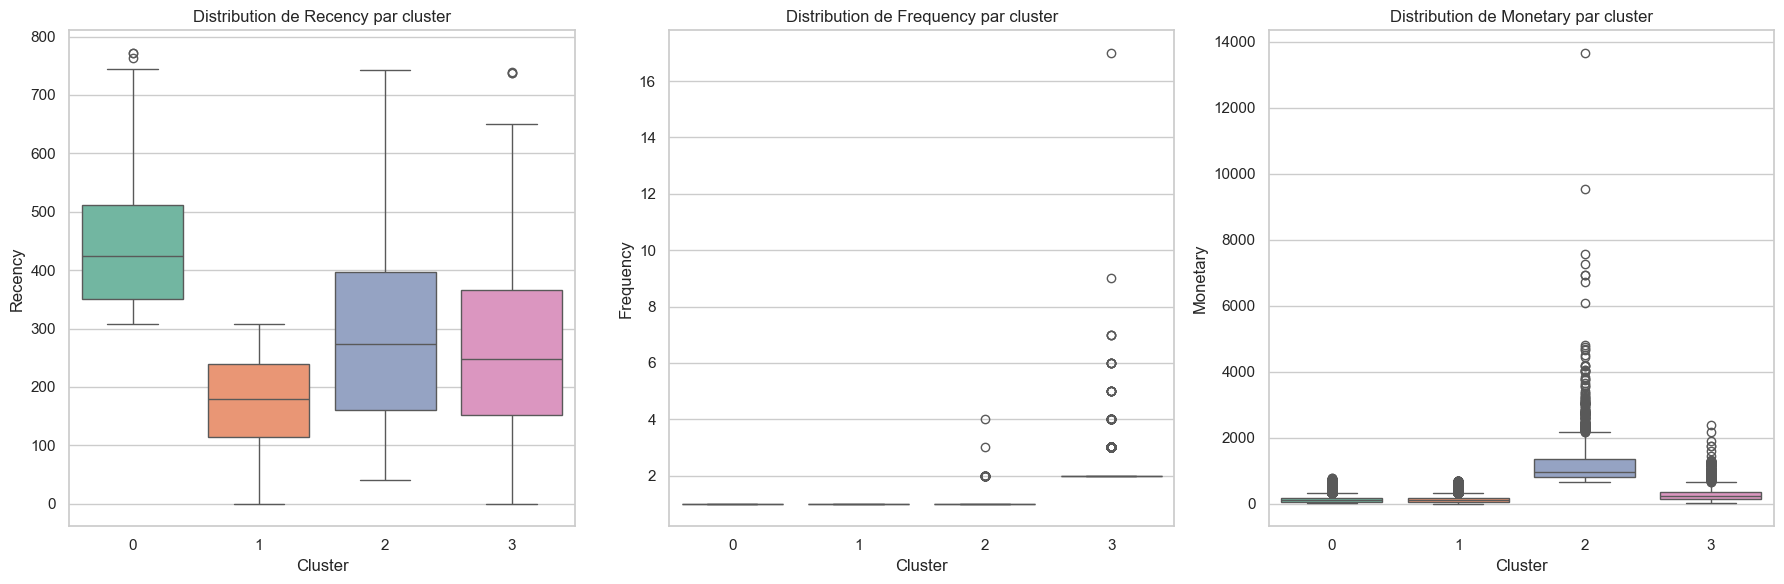

In [601]:
# Définir le style
sns.set(style="whitegrid")

# Créer les sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Tracer les box plots
sns.boxplot(x='kmeans_cluster', y='recency', data=df, ax=axes[0], palette='Set2')
axes[0].set_title('Distribution de Recency par cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Recency')

sns.boxplot(x='kmeans_cluster', y='frequency', data=df, ax=axes[1], palette='Set2')
axes[1].set_title('Distribution de Frequency par cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Frequency')

sns.boxplot(x='kmeans_cluster', y='monetary', data=df, ax=axes[2], palette='Set2')
axes[2].set_title('Distribution de Monetary par cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Monetary')

# Ajuster les espacements
plt.tight_layout()
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_7540\1159729647.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y='recency_log', data=df_log, ax=axes[0], palette='Set2')
C:\Users\david\AppData\Local\Temp\ipykernel_7540\1159729647.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y='frequency_log', data=df_log, ax=axes[1], palette='Set2')
C:\Users\david\AppData\Local\Temp\ipykernel_7540\1159729647.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y='monetary_log', data=df_log,

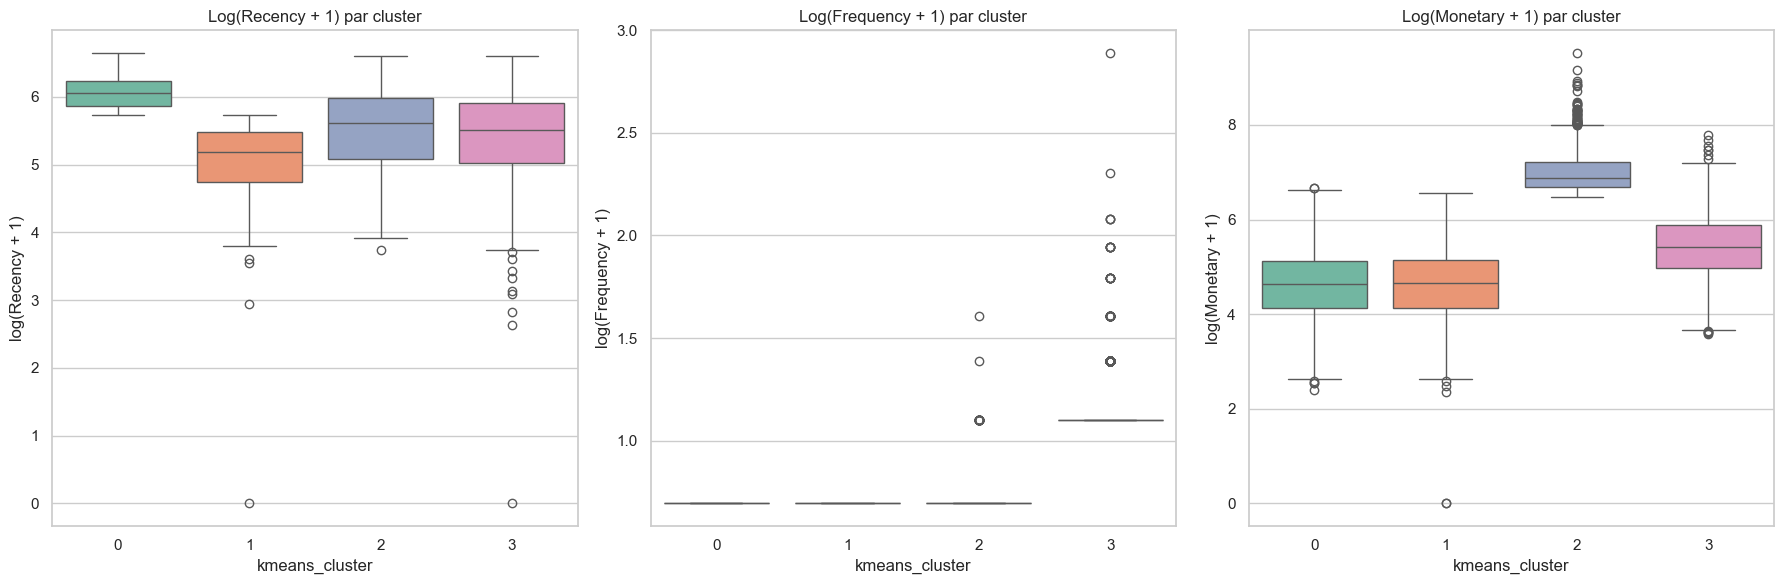

In [602]:
sns.set(style="whitegrid")

# Créer une copie transformée du DataFrame
df_log = df.copy()
df_log['recency_log'] = np.log1p(df_log['recency'])
df_log['frequency_log'] = np.log1p(df_log['frequency'])
df_log['monetary_log'] = np.log1p(df_log['monetary'])

# Tracer les box plots transformés
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='kmeans_cluster', y='recency_log', data=df_log, ax=axes[0], palette='Set2')
axes[0].set_title('Log(Recency + 1) par cluster')
axes[0].set_ylabel('log(Recency + 1)')

sns.boxplot(x='kmeans_cluster', y='frequency_log', data=df_log, ax=axes[1], palette='Set2')
axes[1].set_title('Log(Frequency + 1) par cluster')
axes[1].set_ylabel('log(Frequency + 1)')

sns.boxplot(x='kmeans_cluster', y='monetary_log', data=df_log, ax=axes[2], palette='Set2')
axes[2].set_title('Log(Monetary + 1) par cluster')
axes[2].set_ylabel('log(Monetary + 1)')

plt.tight_layout()
plt.show()

| Cluster                  | Couleur | Récence moyenne | Fréquence moyenne | Dépense moyenne (R$) | Profil                                         | Action recommandée                                                                 |
|--------------------------|---------|------------------|--------------------|------------------------|------------------------------------------------|-------------------------------------------------------------------------------------|
| 0 – Clients à réactiver  | 🟩 Vert | 438 jours         | 1.00               | 135 R$                 | Clients très inactifs, peu fidèles             | Relancer avec campagnes promotionnelles, emails de retour, codes de réduction       |
| 1 – Nouveaux clients     | 🟧 Orange | 177 jours         | 1.00               | 135 R$                 | Clients récents, encore peu engagés            | Stimuler un second achat avec emails de bienvenue, relances, offres personnalisées  |
| 2 – Clients premium      | 🔵 Bleu | 288 jours         | 1.02               | 1 196 R$               | Gros paniers, peu fréquents                    | Offrir des expériences haut de gamme, accès privé, produits premium                 |
| 3 – Clients fidèles      | 🟣 Violet | 268 jours         | 2.12               | 290 R$                 | Achats fréquents et réguliers                  | Fidéliser avec avantages exclusifs, programme de points, contenus personnalisés     |


🟩 Cluster 0 – Clients à réactiver
Couleur : Vert

Récence moyenne : 438 jours → Clients très inactifs

Fréquence moyenne : 1 → Acheté une seule fois

Dépense moyenne : 135 R$ → Panier modéré

Profil : Ces clients n'ont pas commandé depuis très longtemps. Peu fidèles.

Action recommandée : Relancer avec des campagnes de réactivation, emails promotionnels, codes de réduction.

🟧 Cluster 1 – Nouveaux clients
Couleur : Orange

Récence moyenne : 177 jours → Clients récents

Fréquence moyenne : 1 → Acheté une seule fois

Dépense moyenne : 135 R$ → Panier modéré

Profil : Récents mais n'ont pas encore racheté. Possibles à fidéliser.

Action recommandée : Encourager un second achat (programme de bienvenue, suivi de commande, suggestions personnalisées).

🔵 Cluster 2 – Clients premium
Couleur : Bleu

Récence moyenne : 288 jours

Fréquence moyenne : 1.02 → Acheté une fois, voire deux

Dépense moyenne : 1 196 R$ → 💰 Très gros panier

Profil : Peu fréquents mais très rentables.

Action recommandée : Offres haut de gamme, ventes privées, produits premium.

🟣 Cluster 3 – Clients fidèles
Couleur : Violet

Récence moyenne : 268 jours

Fréquence moyenne : 2.1 → Achats répétés

Dépense moyenne : 290 R$ → Panier correct

Profil : Bon niveau de fidélité, clients réguliers.

Action recommandée : Fidélisation : récompenses, contenu personnalisé, programme fidélité.

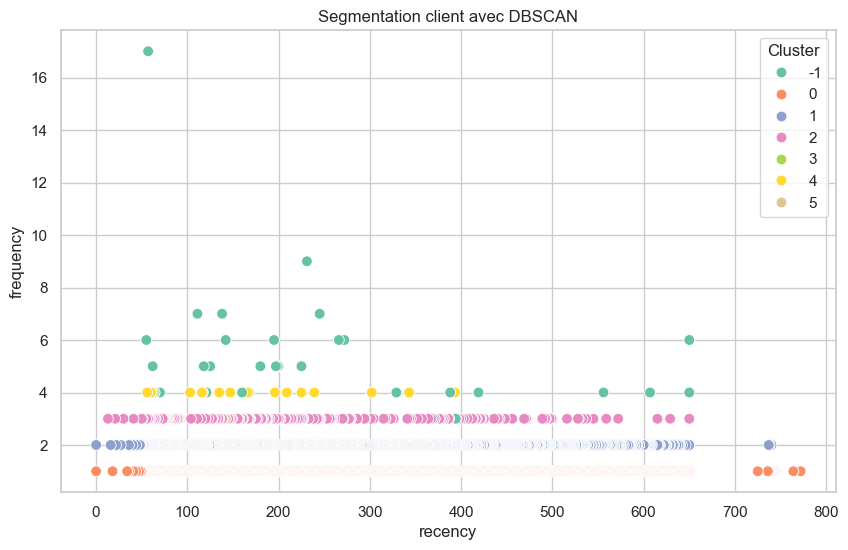

In [603]:
# 1. Sélection des colonnes RFM
# rfm = df[['recency', 'frequency', 'monetary']].copy()

# 2. Normalisation des données
# scaler = StandardScaler()
# rfm_scaled = scaler.fit_transform(rfm)

# 3. Application de DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)  # Tu peux ajuster ces valeurs
clusters = dbscan.fit_predict(rfm_scaled)

# 4. Ajout des clusters au DataFrame
df['dbscan_cluster'] = clusters

# 5. Visualisation 2D avec Seaborn (ex: recency vs frequency)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, x='recency', y='frequency',
    hue='dbscan_cluster', palette='Set2', s=60
)
plt.title("Segmentation client avec DBSCAN")
plt.legend(title="Cluster")
plt.show()

In [605]:
df.groupby('dbscan_cluster')[['recency', 'frequency', 'monetary']].mean()

,recency,frequency,monetary
dbscan_cluster,,,
-1,311.753247,3.077922,2803.088571
0,288.312391,1.000000,160.261179
1,269.980227,2.000000,281.558583
2,255.848958,3.000000,370.110104
3,554.428571,1.000000,3032.300000
4,167.300000,4.000000,542.874000
5,120.000000,3.000000,1313.402000


| Cluster | Interprétation possible                                                                 |
|---------|------------------------------------------------------------------------------------------|
| -1      | Outliers — clients atypiques avec de très hauts montants (2800€), peu nombreux, à analyser séparément. |
| 0       | Clients très basiques : 1 achat, panier moyen faible.                                   |
| 1       | Clients un peu plus fidèles (2 achats), panier moyen moyen.                             |
| 2       | Clients réguliers (3 achats), montant un peu plus élevé.                                |
| 3       | Clients très anciens (recency très élevée), mais très bons paniers. Clients dormants premium ? |
| 4       | Clients récents et très fidèles (4 achats), panier correct. Fidèles à choyer.           |
| 5       | Clients très récents, bons acheteurs, et bons paniers. Champions potentiels.            |


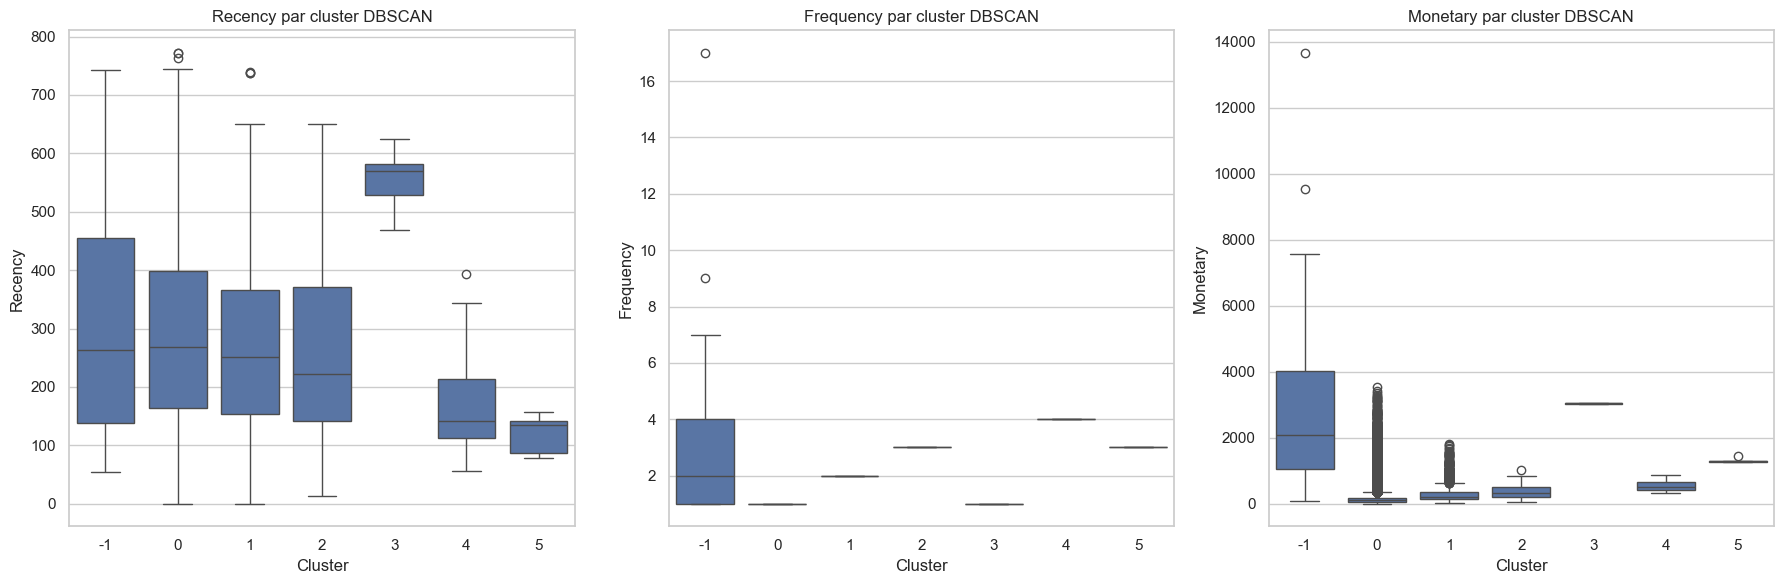

In [606]:
# Créer une figure avec 3 sous-graphiques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Liste des colonnes RFM
rfm_cols = ['recency', 'frequency', 'monetary']
titles = ['Recency', 'Frequency', 'Monetary']

# Boucle pour tracer chaque boxplot
for i, col in enumerate(rfm_cols):
    sns.boxplot(x='dbscan_cluster', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{titles[i]} par cluster DBSCAN')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(titles[i])

plt.tight_layout()
plt.show()

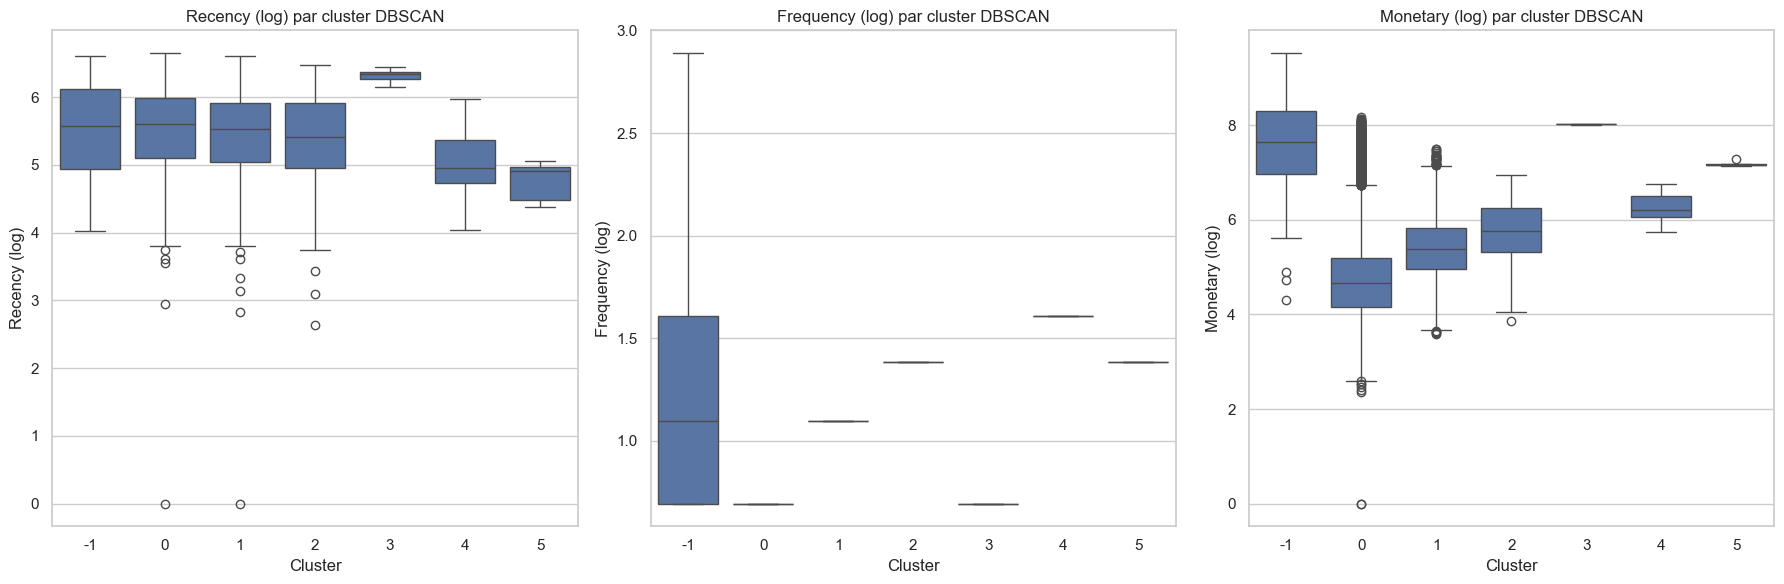

In [607]:
# Création de colonnes transformées en log
df['recency_log'] = np.log1p(df['recency'])
df['frequency_log'] = np.log1p(df['frequency'])
df['monetary_log'] = np.log1p(df['monetary'])

# Tracer les boxplots avec les colonnes log-transformées
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

log_cols = ['recency_log', 'frequency_log', 'monetary_log']
titles = ['Recency (log)', 'Frequency (log)', 'Monetary (log)']

for i, col in enumerate(log_cols):
    sns.boxplot(x='dbscan_cluster', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{titles[i]} par cluster DBSCAN')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(titles[i])

plt.tight_layout()
plt.show()

## Fiches d'identité des groupes DBSCAN

| Cluster | Taille | Profil client                            | Recency (médiane) | Frequency (moyenne) | Monetary (moyenne) | Interprétation |
|---------|--------|------------------------------------------|-------------------|---------------------|--------------------|----------------|
| -1      | ?      | Clients atypiques, potentiellement VIP ou fraudeurs | 311.75           | 3.08               | 2803.09            | 🔍 **Outliers** à analyser : peu nombreux, mais dépensent énormément. Peuvent représenter des cas rares à choyer ou à surveiller. |
| 0       | ?      | Clients peu engagés                      | 288.31            | 1.00               | 160.26             | 💤 Clients très basiques : 1 seul achat avec un petit panier. Faible valeur. |
| 1       | ?      | Clients fidèles modérés                  | 269.98            | 2.00               | 281.56             | 😊 Clients avec 2 achats, panier moyen raisonnable. À fidéliser davantage. |
| 2       | ?      | Clients réguliers                        | 255.85            | 3.00               | 370.11             | 🔁 Bons clients réguliers, à conserver avec des offres adaptées. |
| 3       | ?      | Clients anciens mais à fort potentiel    | 554.43            | 1.00               | 3032.30            | 🕰️ Clients dormants premium : ont peu acheté mais ont un panier énorme. À réactiver. |
| 4       | ?      | Clients fidèles récents                  | 167.30            | 4.00               | 542.87             | 💎 Clients fidèles et récents. À choyer, fort potentiel de réachat. |
| 5       | ?      | Champions potentiels                     | 120.00            | 3.00               | 1313.40            | 👑 Clients très récents, bons acheteurs, à transformer en ambassadeurs. |


🟩 Cluster -1 – Clients atypiques / Outliers
Couleur : Vert foncé

Récence moyenne : 312 jours

Fréquence moyenne : 3

Dépense moyenne : 2 803 €

Profil : Clients rares mais très rentables. Atypiques par leur comportement. Possiblement VIP ou cas spéciaux.

Action recommandée :
🔍 Analyse individuelle. Si clients VIP : traitement personnalisé. Si suspicion de fraude ou incohérence : vérification manuelle.

🟧 Cluster 0 – Clients à réactiver
Couleur : Orange

Récence moyenne : 288 jours

Fréquence moyenne : 1

Dépense moyenne : 160 €

Profil : Clients peu engagés avec un seul achat, et inactifs depuis longtemps.

Action recommandée :
📣 Relancer avec des offres spéciales, des campagnes d’email marketing, ou des bons de réduction.

🟦 Cluster 1 – Clients réguliers mais modérés
Couleur : Bleu

Récence moyenne : 270 jours

Fréquence moyenne : 2

Dépense moyenne : 282 €

Profil : Clients fidèles de niveau moyen. Ils pourraient être fidélisés davantage.

Action recommandée :
📩 Proposer des programmes de fidélité, des ventes privées ou des recommandations ciblées.

🟪 Cluster 2 – Bons clients réguliers
Couleur : Violet

Récence moyenne : 256 jours

Fréquence moyenne : 3

Dépense moyenne : 370 €

Profil : Clients intéressants, revenus plusieurs fois avec un panier convenable.

Action recommandée :
🛍 Fidéliser davantage avec du contenu personnalisé, des invitations VIP ou des récompenses.

🟩 Cluster 3 – Clients dormants premium
Couleur : Vert clair

Récence moyenne : 554 jours

Fréquence moyenne : 1

Dépense moyenne : 3 032 €

Profil : Très anciens clients, peu actifs mais au panier très élevé.

Action recommandée :
🎯 Relancer avec des produits haut de gamme, des rappels personnalisés, ou des avantages exclusifs.

🟨 Cluster 4 – Clients fidèles récents
Couleur : Jaune

Récence moyenne : 167 jours

Fréquence moyenne : 4

Dépense moyenne : 543 €

Profil : Clients actifs, fidèles et récents.

Action recommandée :
💡 Renforcer le lien : offres VIP, programmes fidélité, remerciements personnalisés.

🟫 Cluster 5 – Champions potentiels
Couleur : Marron clair

Récence moyenne : 120 jours

Fréquence moyenne : 3

Dépense moyenne : 1 313 €

Profil : Clients récents et dépensiers. Très prometteurs.

Action recommandée :
👑 Mettre en avant : envoi d’offres exclusives, transformation en ambassadeurs de la marque.

In [604]:
# Fermer la connexion à la base de données
conn.close()